<a href="https://colab.research.google.com/github/parshikondagarla-sketch/predictive-maintenance-ml/blob/main/copy_of_predictive_maintenance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
uploaded = files.upload()


Saving ai4i2020.csv to ai4i2020.csv


In [ ]:
import pandas as pd
df = pd.read_csv("ai4i2020.csv")
df.head()


,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0


In [ ]:
df.drop_duplicates(inplace=True)


In [ ]:
df.isnull().sum()


,0
UDI,0
Product ID,0
Type,0
Air temperature [K],0
Process temperature [K],0
Rotational speed [rpm],0
Torque [Nm],0
Tool wear [min],0
Machine failure,0
TWF,0


In [ ]:
df = pd.get_dummies(df, drop_first=True)


In [ ]:
df['temp_diff'] = df['Process temperature [K]'] - df['Air temperature [K]']


In [ ]:
df['stress'] = df['Torque [Nm]'] * df['Rotational speed [rpm]']


In [ ]:
df['tool_wear_level'] = pd.cut(df['Tool wear [min]'],
                               bins=[0,50,100,150,250],
                               labels=['new','light','medium','heavy'])
df = pd.get_dummies(df, columns=['tool_wear_level'], drop_first=True)


In [ ]:
df['temp_stress'] = df['temp_diff'] * df['stress']


In [ ]:
y = df['Machine failure']
X = df.drop('Machine failure', axis=1)


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [ ]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(X_train_scaled, y_train)


LogisticRegression()

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=200)
rf.fit(X_train, y_train)


RandomForestClassifier(n_estimators=200)

In [ ]:
# FINAL: sanitize cols + train & evaluate LR / RF / XGB
import re
import joblib
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier, XGBRegressor

# ---------- 1) sanitize column names function ----------
def sanitize_cols_df(df):
    """Return copy of df with sanitized column names (only letters/numbers/underscore)."""
    df = df.copy()
    # ensure string type
    df.columns = [str(c) for c in df.columns]
    # replace all non-alphanumeric/_ with underscore and strip underscores
    df.columns = [re.sub(r'[^0-9A-Za-z_]+', '_', c).strip('_') for c in df.columns]
    return df

# ---------- 2) Apply sanitization to your feature DataFrames ----------
# Assumes X_train, X_test (pandas DataFrames) already exist in the notebook.
# If you used scaled versions (X_train_scaled), point to those instead.
try:
    X_train = sanitize_cols_df(X_train)
    X_test  = sanitize_cols_df(X_test)
    print("Sanitized columns:\n", X_train.columns.tolist()[:30], " ...")
except NameError:
    raise RuntimeError("X_train / X_test not found in environment. Create them before running this cell.")

# If you have X_train_scaled / X_test_scaled, sanitize their column names too and use them later if desired:
try:
    X_train_scaled = sanitize_cols_df(pd.DataFrame(X_train_scaled, columns=X_train.columns))
    X_test_scaled  = sanitize_cols_df(pd.DataFrame(X_test_scaled, columns=X_test.columns))
    using_scaled = True
except Exception:
    using_scaled = False

# ---------- 3) Prepare targets (y_train, y_test must exist) ----------
try:
    y_train.shape, y_test.shape
except NameError:
    raise RuntimeError("y_train / y_test not found. Define target variables before running this cell.")

# ---------- 4) Helper evaluation function (regression & classification) ----------
def eval_regression(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    r2 = r2_score(y_true, y_pred)
    return {'mae': mae, 'rmse': rmse, 'r2': r2}

def print_classification_report(y_true, y_pred):
    print(classification_report(y_true, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))

# ---------- 5) Train models ----------
# 5A: Linear Regression (if regression problem)
is_regression = False
if y_train.dtype.kind in 'fc':  # float -> regression target
    is_regression = True

if is_regression:
    # Use scaled features for linear regression if available
    X_lr_tr = X_train_scaled.values if using_scaled else X_train.values
    X_lr_te = X_test_scaled.values if using_scaled else X_test.values

    lr = LinearRegression()
    lr.fit(X_lr_tr, y_train)
    y_pred_lr = lr.predict(X_lr_te)
    res_lr = eval_regression(y_test, y_pred_lr)
    print("Linear Regression (regression) →", res_lr)
    joblib.dump(lr, "model_linear_regression.joblib")
else:
    # classification baseline: Logistic Regression might require scaled input; we keep simple
    try:
        from sklearn.linear_model import LogisticRegression
        X_clf_tr = X_train_scaled.values if using_scaled else X_train.values
        X_clf_te = X_test_scaled.values if using_scaled else X_test.values
        clf_lr = LogisticRegression(max_iter=1000)
        clf_lr.fit(X_clf_tr, y_train)
        y_pred_clf_lr = clf_lr.predict(X_clf_te)
        print("Logistic Regression classification report:")
        print_classification_report(y_test, y_pred_clf_lr)
        joblib.dump(clf_lr, "model_logistic_regression.joblib")
    except Exception as e:
        print("Could not train LogisticRegression:", e)

# 5B: Random Forest
if is_regression:
    rf = RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1)
else:
    rf = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)

rf.fit(X_train.values, y_train)
y_pred_rf = rf.predict(X_test.values)
if is_regression:
    res_rf = eval_regression(y_test, y_pred_rf)
    print("Random Forest (regression) →", res_rf)
else:
    print("Random Forest (classification) report:")
    print_classification_report(y_test, y_pred_rf)
joblib.dump(rf, "model_random_forest.joblib")

# 5C: XGBoost (sanitized names fixed the original error)
if is_regression:
    xgb = XGBRegressor(n_estimators=200, learning_rate=0.05, random_state=42, n_jobs=-1, objective='reg:squarederror', verbosity=0)
else:
    xgb = XGBClassifier(n_estimators=200, learning_rate=0.05, random_state=42, n_jobs=-1, use_label_encoder=False, eval_metric='logloss', verbosity=0)

# Fit using DataFrame (safe because columns sanitized)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)

if is_regression:
    res_xgb = eval_regression(y_test, y_pred_xgb)
    print("XGBoost (regression) →", res_xgb)
else:
    print("XGBoost (classification) report:")
    print_classification_report(y_test, y_pred_xgb)

joblib.dump(xgb, "model_xgboost.joblib")

# ---------- 6) Decide best model (by RMSE for regression or recall for classification) ----------
if is_regression:
    # compare RMSE (lower is better)
    all_res = {'lr': res_lr if 'res_lr' in locals() else None, 'rf': res_rf, 'xgb': res_xgb}
    print("All results:", all_res)
    best = min((k, v['rmse']) for k,v in all_res.items() if v is not None)
    print("Best model by RMSE:", best)
    best_model_name = best[0]
else:
    # pick model with highest recall for positive class (safety-first)
    from sklearn.metrics import recall_score
    rec_lr = recall_score(y_test, y_pred_clf_lr) if 'y_pred_clf_lr' in locals() else -1
    rec_rf = recall_score(y_test, y_pred_rf)
    rec_xgb = recall_score(y_test, y_pred_xgb)
    recalls = {'logreg': rec_lr, 'rf': rec_rf, 'xgb': rec_xgb}
    print("Recalls:", recalls)
    best_model_name = max(recalls, key=recalls.get)
    print("Best model by recall:", best_model_name)

# save best named model filename
best_map = {'lr': 'model_linear_regression.joblib', 'rf': 'model_random_forest.joblib', 'xgb': 'model_xgboost.joblib',
            'logreg':'model_logistic_regression.joblib'}
best_filename = best_map.get(best_model_name, 'model_xgboost.joblib')
print("Best model file:", best_filename)


Sanitized columns:
 ['UDI', 'Air_temperature_K', 'Process_temperature_K', 'Rotational_speed_rpm', 'Torque_Nm', 'Tool_wear_min', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF', 'Product_ID_H29425', 'Product_ID_H29432', 'Product_ID_H29434', 'Product_ID_H29441', 'Product_ID_H29452', 'Product_ID_H29457', 'Product_ID_H29462', 'Product_ID_H29466', 'Product_ID_H29481', 'Product_ID_H29494', 'Product_ID_H29500', 'Product_ID_H29522', 'Product_ID_H29525', 'Product_ID_H29550', 'Product_ID_H29552', 'Product_ID_H29557', 'Product_ID_H29560', 'Product_ID_H29569', 'Product_ID_H29571']  ...
Logistic Regression classification report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1939
           1       1.00      0.25      0.39        61

    accuracy                           0.98      2000
   macro avg       0.99      0.62      0.69      2000
weighted avg       0.98      0.98      0.97      2000

Confusion Matrix:
 [[1939    0]
 [  46   15]]
Random Forest (cl

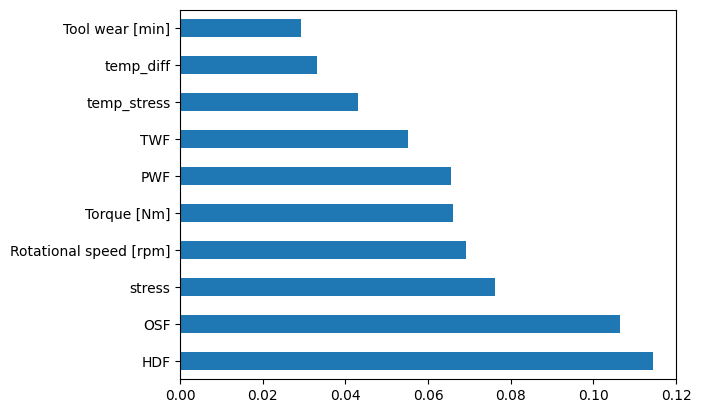

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

feat_imp = pd.Series(rf.feature_importances_, index=X.columns)
feat_imp.nlargest(10).plot(kind='barh')
plt.show()


In [ ]:
import joblib
joblib.dump(rf, "predictive_maintenance_model.pkl")


['predictive_maintenance_model.pkl']